In [164]:
import requests
import json
import re
import pandas as pd
import sklearn
import os
import nltk
import string
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import random
import seaborn as sns
import newspaper

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup 
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.decomposition import PCA
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from newspaper import Article

In [ ]:
client_id = "yxeLnXDdwoDJunEPDRUgYVmH-I703sGZKWGoCdKbFNupYKHugalkOVqtzh3aSe82"
client_secret = "zd3utRAeYAprwImrgEPERa6BPjNrJMOcg4ogsbTAR-uCoIoh9zu28ufhMVRYlBTpb8kSHkWK75LDrHSerdEOag"
client_access_token = "wVsdPF-_vbLLypQZ3qaR0EwytwJW2jKBsK-PoZwv6BDKQLDK0gkUwstOYuH-EDD2"

def request_song_info(artist_name, song_title):
    base_url = 'https://api.genius.com'
    headers = {'Authorization': f'Bearer {client_access_token}'}
    search_url = base_url + '/search'
    params = {'q': f'{artist_name} {song_title}'}

    response = requests.get(search_url, params = params, headers = headers)
    return response

def request_song_url(artist_name, song_titles):
    # Input is song titles, want to find associated urls with each
    urls = []
    track_names = []

    for song in song_titles:
        #print(song)
        song = re.sub("´", "'", song)
        song = re.sub("  ", " ", song)
        response = request_song_info(artist_name, song)
        json = response.json()
    
        # Extract the first matching song URL
        hit = json['response']['hits'][0]['result']
        #print(hit)
        #print(hit['title'].lower())
        if (artist_name.lower() in hit['primary_artist']['name'].lower()):
            song_url = hit['url']
            urls.append(song_url)
            
            match = re.search(r'beatles-(.*?)-lyrics', song_url)
    
            if match:
                result = match.group(1) 
                track_names.append(result)
        
    # Return both the URL and the song title
    return [urls, track_names] 

# First want to only have songs that are composed by lennon or mccartney
os.chdir("C:/Users/maede/Downloads/Python/INFO5653/Project/Project/INFO5653_Project")
df = pd.read_csv("song_composer_singer.csv")
df.columns = ["Song", "Composer", "Singer"]
lennon_mccartney = df[df['Composer'].isin(["Lennon", "McCartney"])]

# Now want to match songs from this set to the lyrics pulled from genuis api
l_m_songs = list(lennon_mccartney['Song'])

# Composer list
l_m_composer = list(lennon_mccartney['Composer'])

# Find urls!
artist_name = "The Beatles"
[urls, song_titles] = request_song_url(artist_name, l_m_songs)

# Scrape lyrics from a Genius.com song URL
def scrape_song_lyrics(url):
    song = requests.get(url)
    html = BeautifulSoup(song.content, 'html.parser')
    lyrics_divs = html.find_all("div", {"data-lyrics-container": "true"})
    
    if lyrics_divs:
        lyrics = "\n".join(div.get_text(separator="\n") for div in lyrics_divs)
        # Remove identifiers like chorus, verse, etc
        lyrics = re.sub(r'[\(\[].*?[\)\]]', '', lyrics, flags=re.DOTALL).strip()
        
        # Remove empty lines
        lyrics = os.linesep.join([s for s in lyrics.splitlines() if s])  
    else:
        print("Lyrics not found!")
        lyrics = ""
    
    return lyrics

def write_lyrics_to_corpus(urls, track_names, composer, path):
    for i in range(len(track_names)):
        # Get url and title
        url = urls[i]
        title = track_names[i]
        label = composer[i]
        title = re.sub(" ", "-", title)
        title = re.sub(r"\?", "", title)
        title = title.lower()
    
        # Create file, mypath, and filename
        file = str(label) + '-' + str(title) + ".txt"
        filename = mypath + "/" + file
    
        # Open file to write to
        my_file = open(filename, "w", encoding = "utf-8")
    
        # Find lyrics
        lyrics = scrape_song_lyrics(url)
        my_file.write(lyrics)
        my_file.close()

mypath = "C:/Users/maede/Downloads/Python/INFO5653/Project/Project/INFO5653_Project/Composer_Lyrics_Corpus"
write_lyrics_to_corpus(urls, song_titles, l_m_composer, mypath)

In [ ]:
########## PART 3: USE CORPUS TO BUILD DATAFRAME ##########

# Path to corpus
path = "C:/Users/maede/Downloads/Python/INFO5653/Project/Project/INFO5653_Project/Composer_Lyrics_Corpus"

# Create file name
file_name_list = os.listdir(path)[1:]

# Initliaze empty lists that will be filled later with all file paths in corpus
complete_file_paths = [] 
list_file_names = []
    
for name in file_name_list:
    nextfile = path + "/" + name 
    complete_file_paths.append(nextfile) 
    nextnameL = name.split(".")
    list_file_names.append(nextnameL[0])

# LDA for Lyrics! 2 topics

In [237]:
# USE COUNTVECTORIZOR AND LET MAX_FEATURES = 100

# Now we can use CountVectorizer 
my_vect = CountVectorizer(input = 'filename', stop_words = 'english', token_pattern=r'\b[a-zA-Z]{4,}\b', max_features = 100)
fit = my_vect.fit_transform(complete_file_paths)
column_names = my_vect.get_feature_names_out()

# Convert to dataframe
lyrics_df = pd.DataFrame(fit.toarray(),columns = column_names)

# Add labels using a dictionary
dict_labels = {}

for i in range(0, len(complete_file_paths)):
    dict_labels[i] = list_file_names[i].split("-")[0]

lyrics_df = lyrics_df.rename(dict_labels, axis = "index")
lyrics_df.index.name = "LABEL"

# Write dataframe to csv
lyrics_df.to_csv("paul_john_lyrics_corpus_count100.csv", index = True)

In [238]:
# Read in file
lyrics = pd.read_csv("paul_john_lyrics_corpus_count100.csv")

# Get labels and change to numbers
labels = lyrics['LABEL']

# Remove labels
lyrics_unlabeled = lyrics.drop("LABEL", axis = 1)

In [239]:
########## LDA Topics Modeling ##########
random.seed(1)
num_topics = 2
lda_model = LatentDirichletAllocation(n_components = num_topics, max_iter = 100, learning_method = 'online')
   
lda_df = lda_model.fit_transform(lyrics_unlabeled)

def print_topics(model, vectorizer, top_n = 10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                    for i in topic.argsort()[:-top_n - 1:-1]])

top_n = 15
print_topics(lda_model, my_vect, top_n)

Topic 0:
[('yellow', 160.8450380295034), ('submarine', 153.97400461624565), ('home', 127.30330327367456), ('road', 105.16932102161522), ('yeah', 78.49710949433133), ('come', 54.3278463656482), ('going', 47.588371508423975), ('want', 40.3207050855161), ('like', 37.55761238759925), ('mind', 31.62986473597973), ('life', 31.457422336958388), ('better', 28.282721282230263), ('time', 26.951988288140928), ('tell', 23.800479887599273), ('getting', 23.62869837330568)]
Topic 1:
[('love', 325.7694139574212), ('know', 224.5967923708912), ('girl', 112.77779118079268), ('mother', 111.63298774100166), ('need', 108.6300327085663), ('little', 103.42671151167042), ('good', 96.99102017909398), ('help', 93.92189741782347), ('time', 93.47035334277257), ('long', 80.34131508575072), ('gonna', 73.70735271720784), ('said', 72.81711904766759), ('away', 72.43351997199161), ('honey', 60.62064211870006), ('children', 59.98499993626184)]


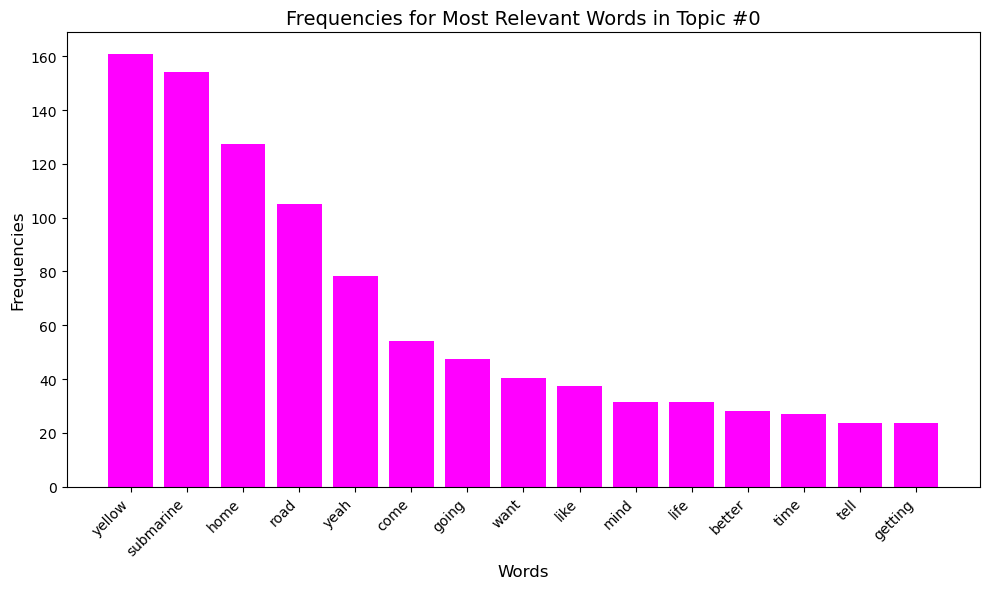

In [240]:
# BAR CHART 
topics = []
for idx, topic in enumerate(lda_model.components_):
    topics.append([(my_vect.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]])

words0, frequencies0 = zip(*topics[0])
words0 = list(words0)
frequencies0 = list(frequencies0)

words1, frequencies1 = zip(*topics[1])
words1 = list(words1)
frequencies1 = list(frequencies1)

# Plot it
# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(words0, frequencies0, color='magenta')

# Add title and labels
plt.title('Frequencies for Most Relevant Words in Topic #0', fontsize=14)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequencies', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

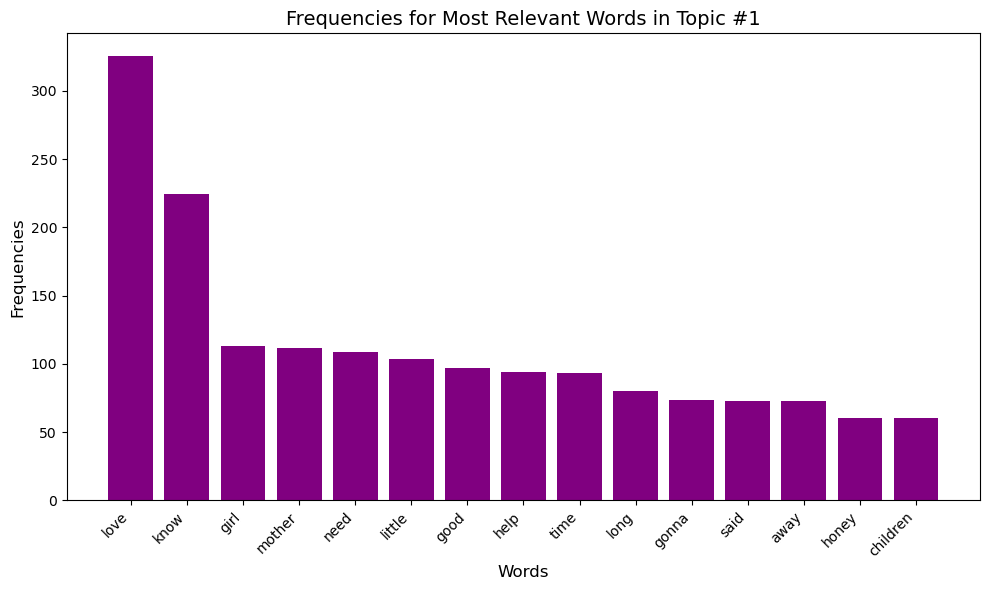

In [241]:
# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(words1, frequencies1, color='purple')

# Add title and labels
plt.title('Frequencies for Most Relevant Words in Topic #1', fontsize=14)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequencies', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

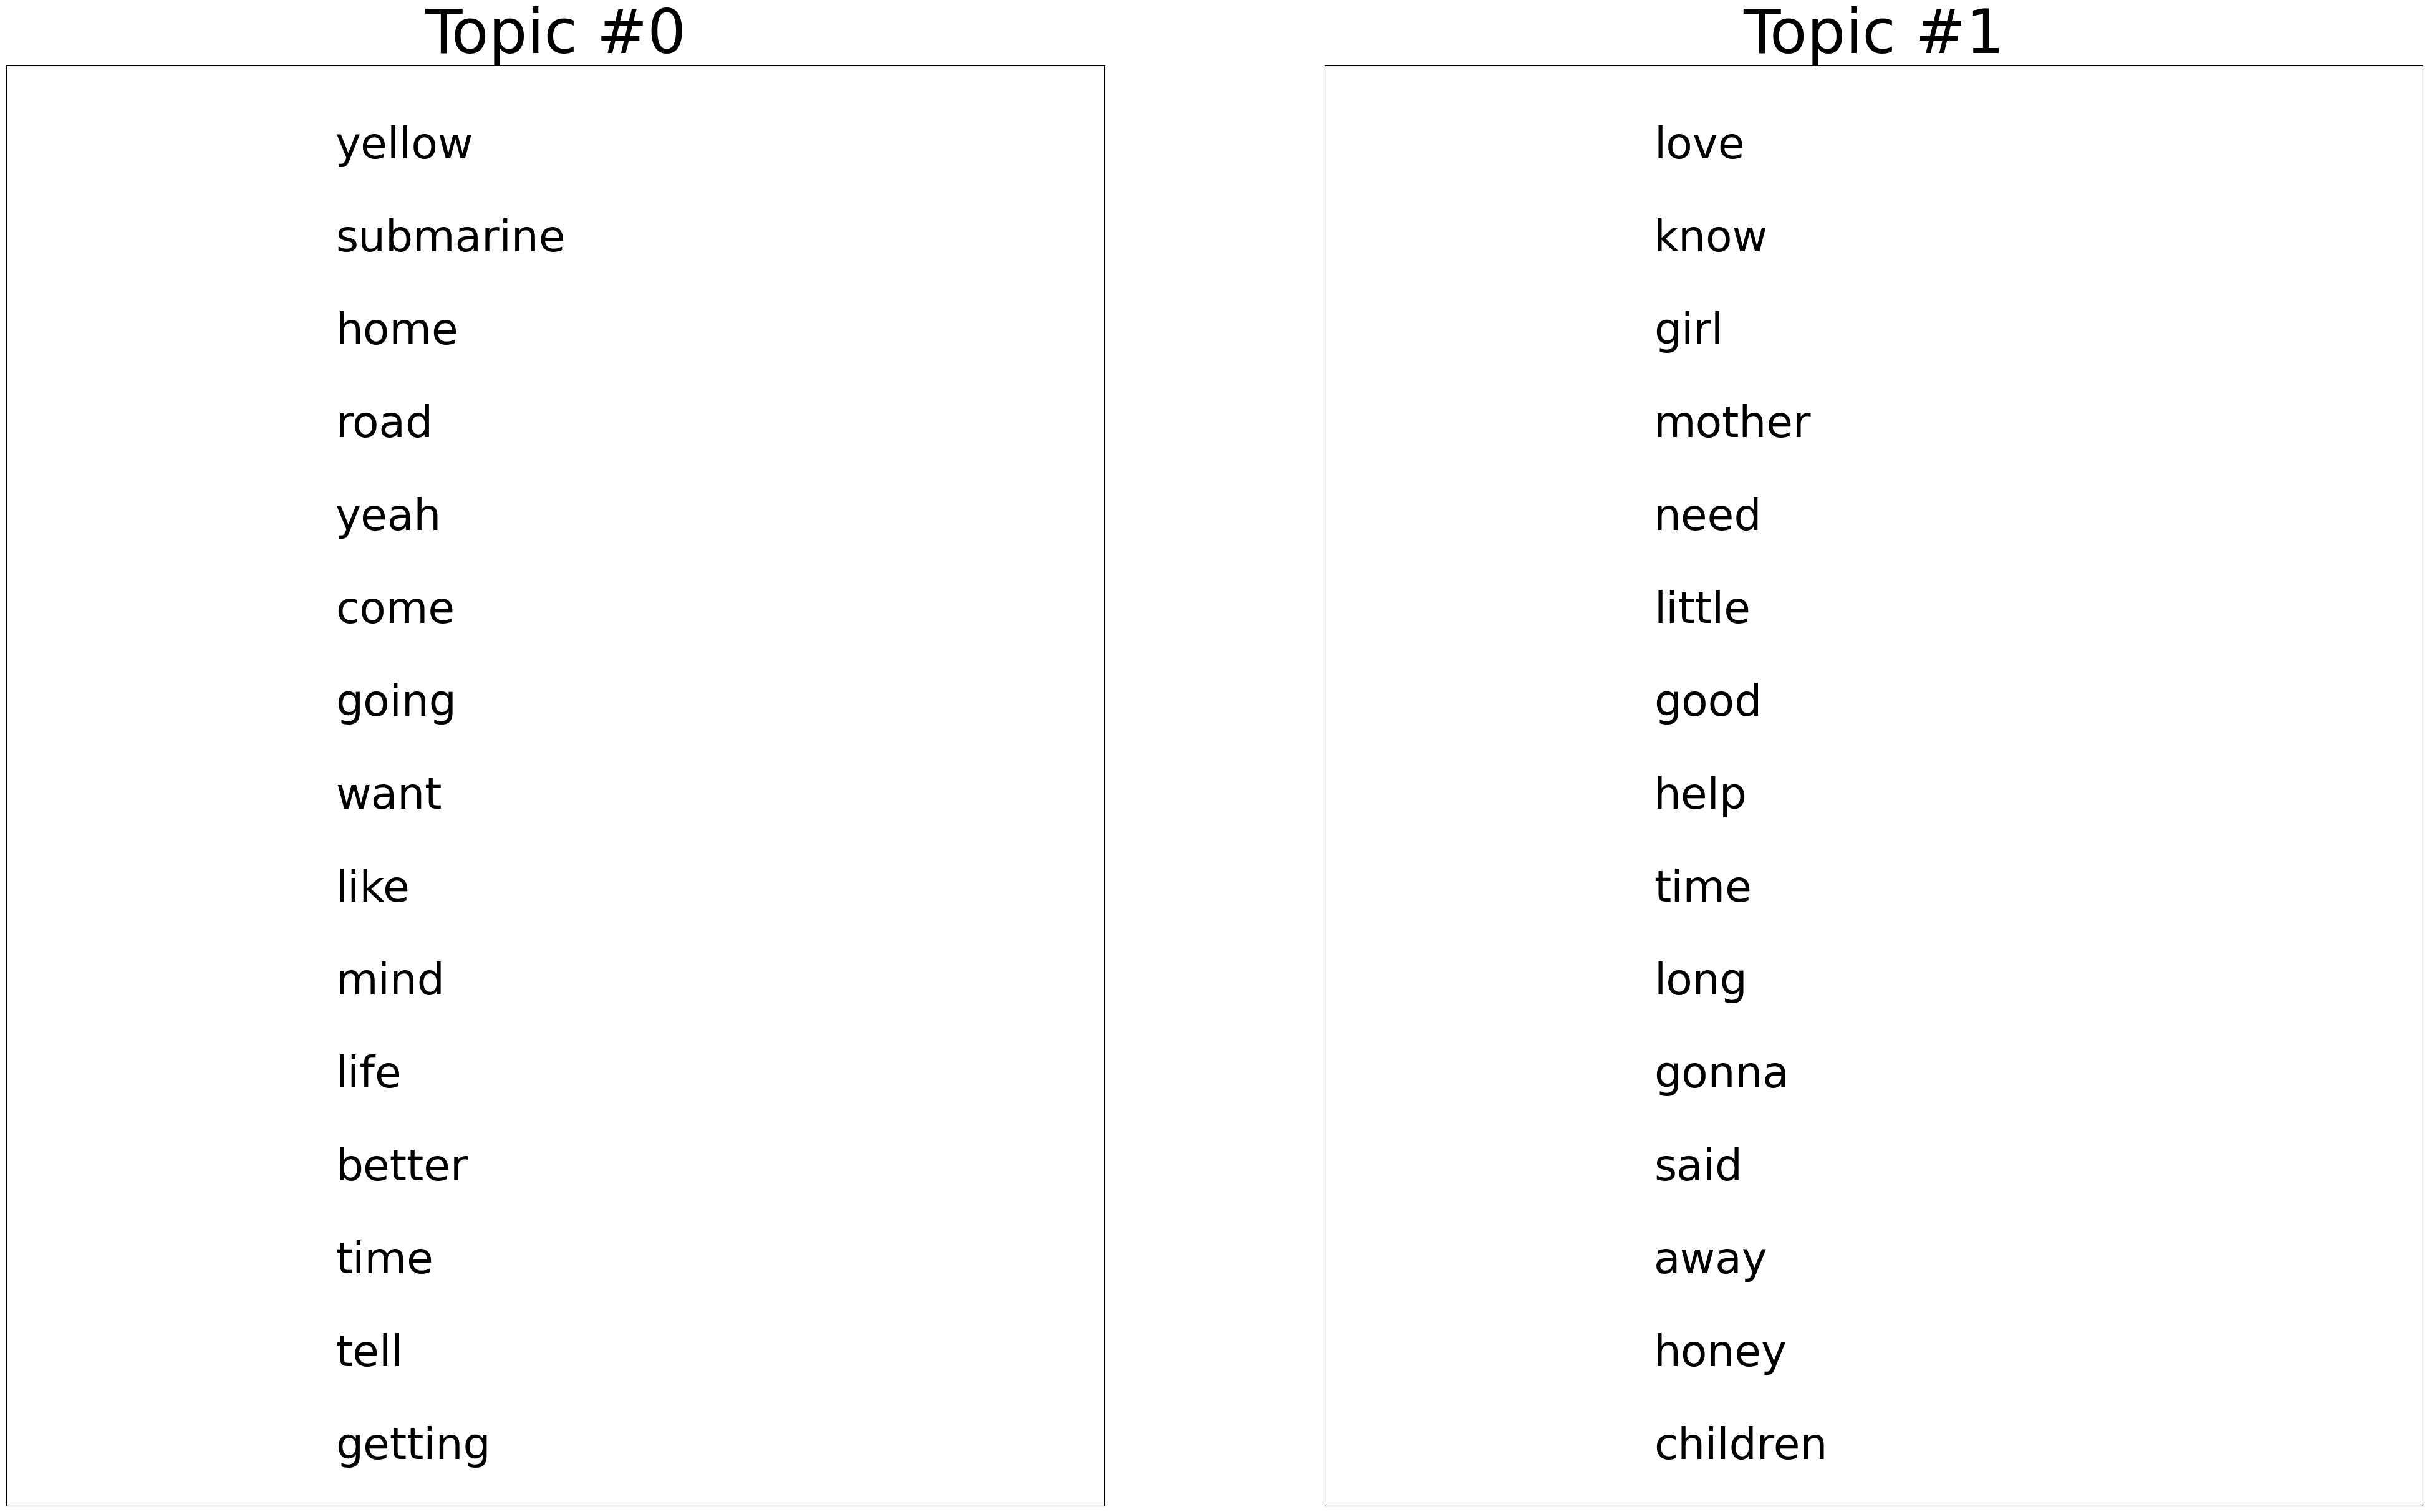

In [242]:
# Plot it!
plt.figure(figsize=(50,30))
word_topic = np.array(lda_model.components_)
word_topic = word_topic.transpose()

num_top_words = top_n
ColumnNames = lyrics_unlabeled.columns.tolist()
vocab_array = np.asarray(ColumnNames)

for t in range(num_topics):
    plt.subplot(1, num_topics, t + 1)  # plot numbering starts with 1
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(t), size = 70)
    top_words_idx = np.argsort(word_topic[:,t])[::-1]  # descending order
    top_words_idx = top_words_idx[:num_top_words]
    top_words = vocab_array[top_words_idx]
    top_words_shares = word_topic[top_words_idx, t]
    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        plt.text(0.3, num_top_words-i -0.5, word, fontsize = 50)

plt.show()

# 4 topics?

In [243]:
########## LDA Topics Modeling ##########
random.seed(1)
num_topics = 4
lda_model2 = LatentDirichletAllocation(n_components = num_topics, max_iter = 100, learning_method = 'online')
   
lda_df2 = lda_model2.fit_transform(lyrics_unlabeled)

def print_topics(model, vectorizer, top_n = 10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                    for i in topic.argsort()[:-top_n - 1:-1]])

top_n = 15
print_topics(lda_model2, my_vect2, top_n)

Topic 0:
[('leak', 127.06779697938555), ('year', 62.18030021303993), ('life', 60.39903226093639), ('hear', 46.503049160054225), ('spreadsheet', 30.952249862923377), ('couple', 28.55453094716507), ('band', 21.487975320129582), ('good', 20.20759384929452), ('koze', 18.079019921711065), ('important', 16.41061188849268), ('beatles', 15.376275662307764), ('love', 14.866990334455748), ('single', 14.692399676314716), ('admin', 14.283544994229592), ('really', 13.95143862408885)]
Topic 1:
[('looked', 166.48973722040665), ('place', 111.40100268503159), ('home', 96.5300440690602), ('studio', 79.40562107633228), ('middle', 77.57883838951959), ('country', 58.443532945138465), ('paul', 26.039859865956142), ('days', 25.972938922428302), ('songs', 25.92966946286215), ('night', 25.7118866703138), ('player', 23.681642081781938), ('petty', 22.892350981921787), ('benny', 21.739159082542784), ('heard', 21.063318113916942), ('time', 18.7946158469148)]
Topic 2:
[('molland', 316.1354100241607), ('years', 154.

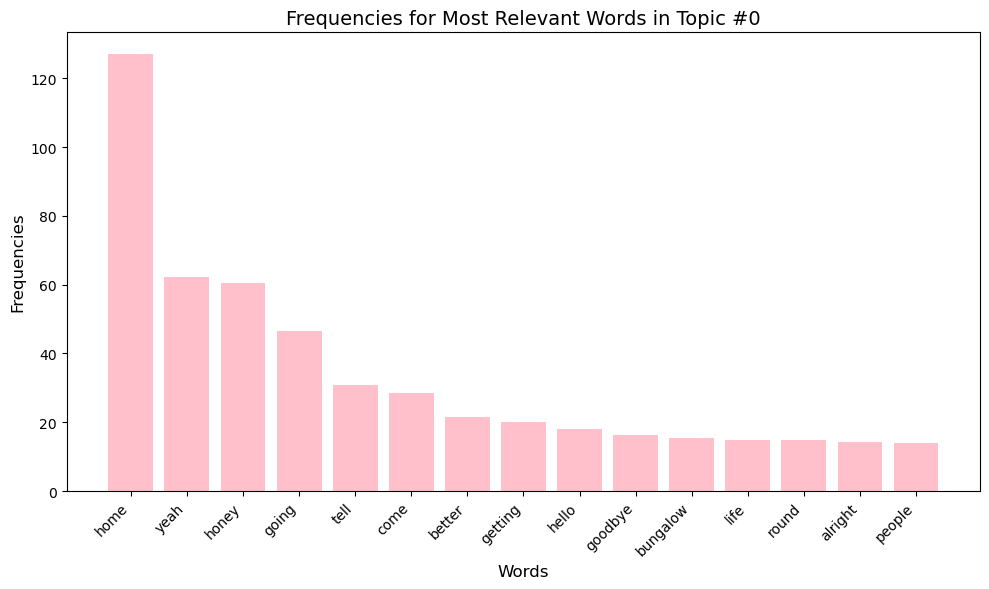

In [255]:
# BAR CHART 
topics = []
for idx, topic in enumerate(lda_model2.components_):
    topics.append([(my_vect.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]])

words0, frequencies0 = zip(*topics[0])
words0 = list(words0)
frequencies0 = list(frequencies0)

words1, frequencies1 = zip(*topics[1])
words1 = list(words1)
frequencies1 = list(frequencies1)

words2, frequencies2 = zip(*topics[2])
words2 = list(words2)
frequencies2 = list(frequencies2)

words3, frequencies3 = zip(*topics[3])
words3 = list(words3)
frequencies3 = list(frequencies3)

# Plot it
# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(words0, frequencies0, color='pink')

# Add title and labels
plt.title('Frequencies for Most Relevant Words in Topic #0', fontsize=14)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequencies', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

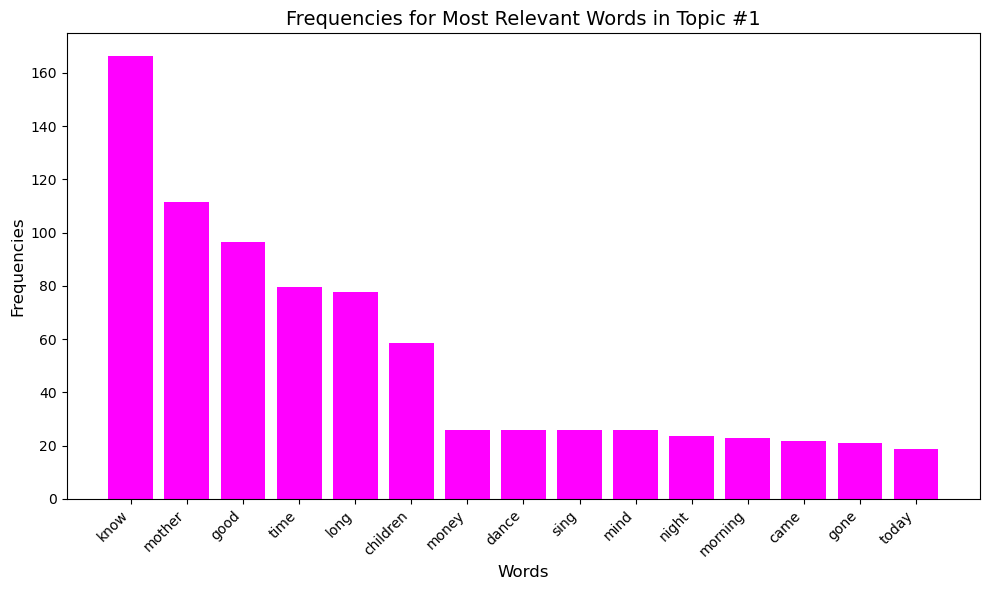

In [254]:
# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(words1, frequencies1, color='magenta')

# Add title and labels
plt.title('Frequencies for Most Relevant Words in Topic #1', fontsize=14)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequencies', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

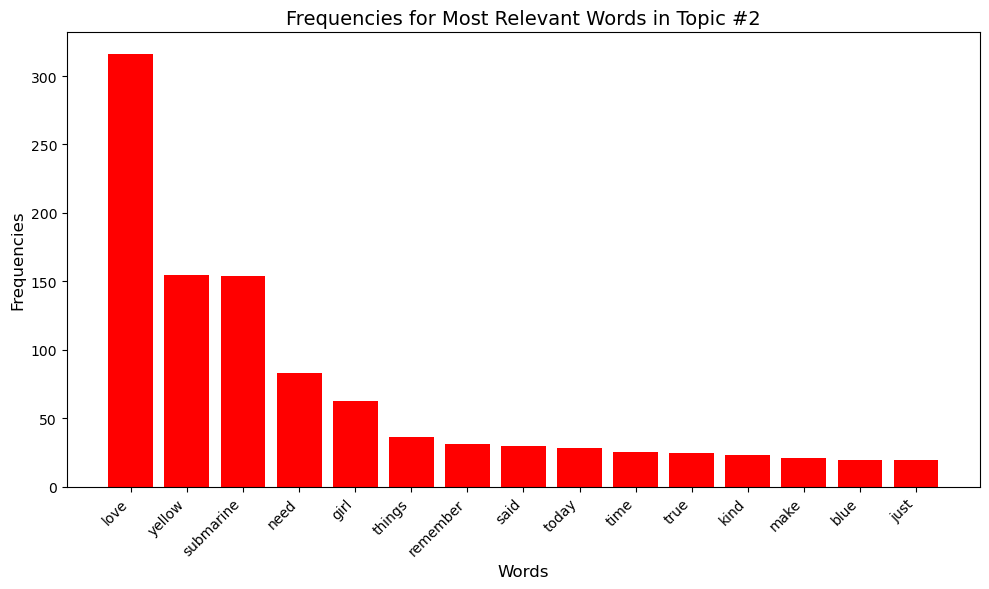

In [251]:
# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(words2, frequencies2, color='red')

# Add title and labels
plt.title('Frequencies for Most Relevant Words in Topic #2', fontsize=14)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequencies', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

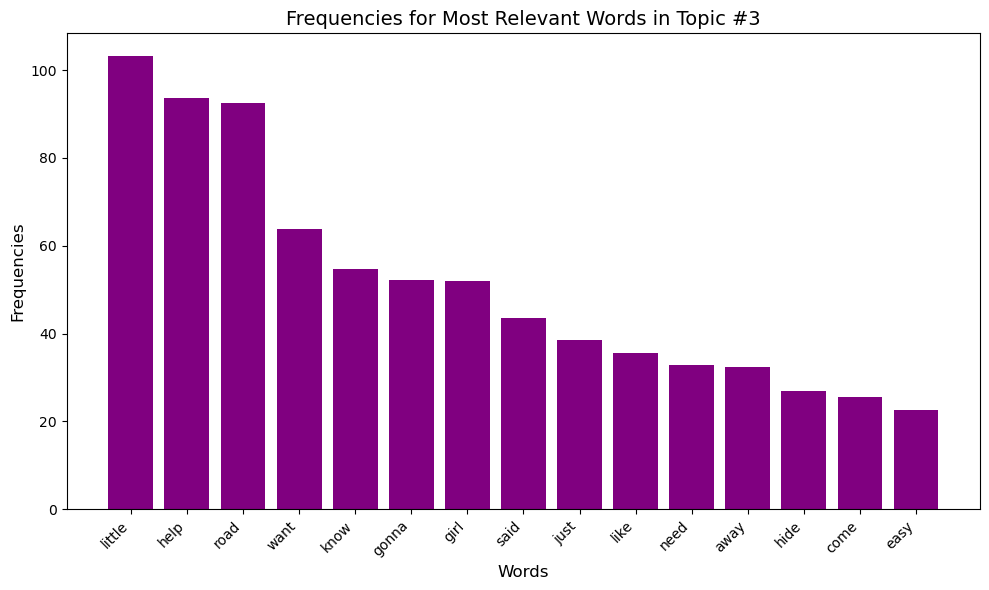

In [250]:
# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(words3, frequencies3, color='purple')

# Add title and labels
plt.title('Frequencies for Most Relevant Words in Topic #3', fontsize=14)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequencies', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

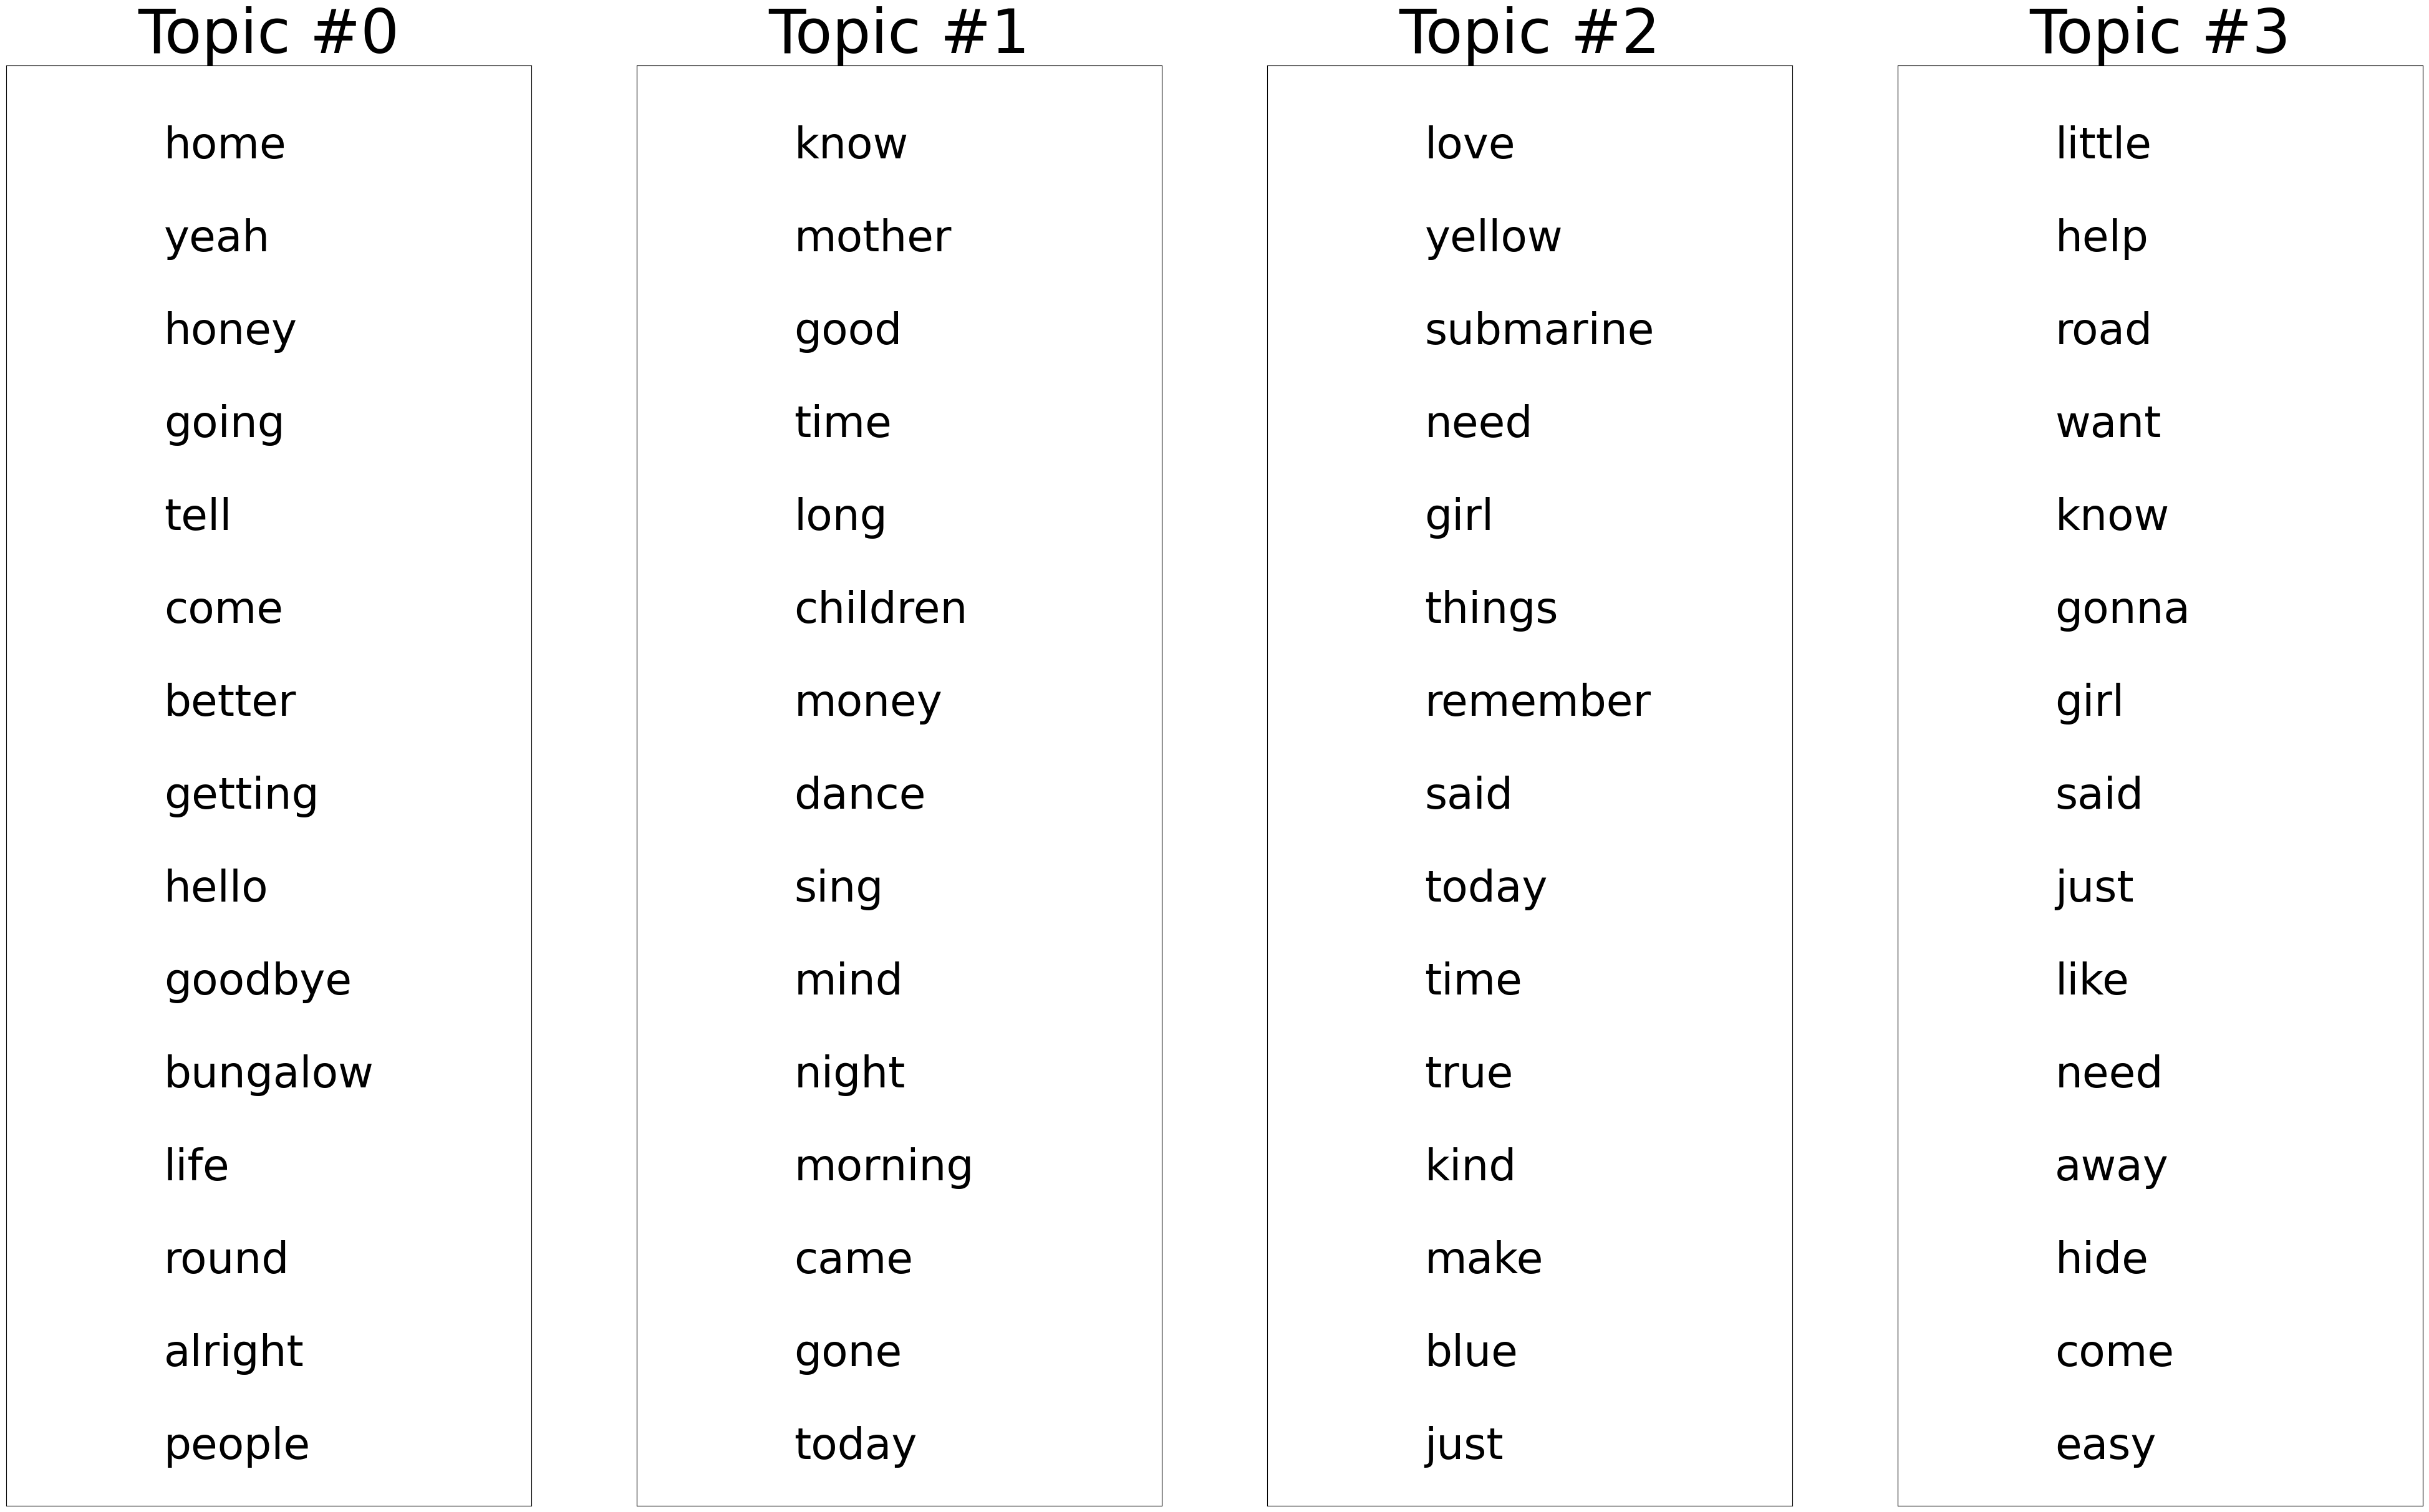

In [256]:
# Plot it!
plt.figure(figsize=(50,30))
word_topic = np.array(lda_model2.components_)
word_topic = word_topic.transpose()

num_top_words = top_n
ColumnNames = lyrics_unlabeled.columns.tolist()
vocab_array = np.asarray(ColumnNames)

for t in range(num_topics):
    plt.subplot(1, num_topics, t + 1)  # plot numbering starts with 1
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(t), size = 70)
    top_words_idx = np.argsort(word_topic[:,t])[::-1]  # descending order
    top_words_idx = top_words_idx[:num_top_words]
    top_words = vocab_array[top_words_idx]
    top_words_shares = word_topic[top_words_idx, t]
    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        plt.text(0.3, num_top_words-i -0.5, word, fontsize = 50)

plt.show()